# Benchmarking SimSon Embeddings vs Classical Cheminformatics Similarity Methods

This notebook runs a reproducible mini-benchmark comparing **SimSon** embeddings (dense vectors) against classical non-deep-learning similarity methods (ECFP4 fingerprints + Tanimoto, MACCS, and an optional MinHash/LSH baseline).

It includes:
- environment setup (package installs, version checks)
- data loading (CSV with SMILES or example ChEMBL/BACE subset)
- fingerprint and embedding computation/loading
- nearest-neighbour retrieval experiments (recall@k, overlap)
- a simple activity-enrichment test (ROC-AUC / EF)
- scaffold-based split for cross-validation
- speed / indexing example using FAISS (for vector embeddings)

### Notes
- Placeholders: `bace_subset.csv`, `simson_embeddings.npy` or a `simson` Python module.
- The notebook is intentionally defensive: if a fast library isn't available it falls back to pure-Python / RDKit implementations.

## 1) Environment setup — install required packages

In [ ]:
import sys, subprocess
def pip_install(packages):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade'] + packages)

try:
    pip_install(['rdkit', 'numpy', 'pandas', 'scikit-learn', 'matplotlib', 'tqdm', 'faiss-cpu', 'scipy', 'datasketch', 'deepchem'])
except Exception as e:
    print('Automatic pip install failed:', e)
print('Done.')

## 2) Imports and version checks

In [1]:
import os, time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold
print('RDKit:', rdkit.__version__)

try:
    import faiss
    print('FAISS:', faiss.__version__)
except Exception:
    faiss = None
    print('FAISS not available')

from sklearn.metrics import roc_auc_score
from scipy.stats import wilcoxon
import sklearn
print('sklearn:', sklearn.__version__)

RDKit: 2025.09.1
FAISS: 1.12.0
sklearn: 1.7.2


In [2]:
import deepchem as dc

print("Downloading BACE dataset (binary activity)...")
tasks, datasets, transformers = dc.molnet.load_bace_classification(
    featurizer="Raw",
    splitter="scaffold"   # <-- fixed (no deprecated split=)
)

train_dataset, valid_dataset, test_dataset = datasets
print("Train:", len(train_dataset), "Valid:", len(valid_dataset), "Test:", len(test_dataset))

df_train = pd.DataFrame({"smiles": train_dataset.ids, "active": train_dataset.y.flatten().astype(int)})
df_valid = pd.DataFrame({"smiles": valid_dataset.ids, "active": valid_dataset.y.flatten().astype(int)})
df_test  = pd.DataFrame({"smiles": test_dataset.ids,  "active": test_dataset.y.flatten().astype(int)})

df = pd.concat([df_train, df_valid, df_test], ignore_index=True)
df.to_csv("bace_subset.csv", index=False)
print("Saved as bace_subset.csv")
df.head()

/home/bagugu/molsearch/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bagugu/molsearch/venv/lib/python3.12/site-packages/deepchem/feat/smiles_tokenizer.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-11-16 10:54:26.803863: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Train: 1210 Valid: 151 Test: 152
Saved as bace_subset.csv


,smiles,active
0,Fc1ccc(cc1C#CCCCF)[C@]1(N=C(N)N(C)C1=O)c1ccc(O...,1
1,FCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(F...,1
2,FCCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(...,1
3,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...,1
4,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...,1


## 3) Load dataset

In [3]:
DATA_CSV = 'bace_subset.csv'

df = pd.read_csv(DATA_CSV)
df = df.dropna(subset=['smiles']).reset_index(drop=True)
df['rdkit_mol'] = df['smiles'].apply(Chem.MolFromSmiles)
df = df[df['rdkit_mol'].notna()].reset_index(drop=True)
print('Loaded dataset:', df.shape)
df.head()

Loaded dataset: (1513, 3)


,smiles,active,rdkit_mol
0,Fc1ccc(cc1C#CCCCF)[C@]1(N=C(N)N(C)C1=O)c1ccc(O...,1,<rdkit.Chem.rdchem.Mol object at 0x71be2d0155b0>
1,FCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(F...,1,<rdkit.Chem.rdchem.Mol object at 0x71be2d015620>
2,FCCC#Cc1cc(ccc1)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(...,1,<rdkit.Chem.rdchem.Mol object at 0x71be2d015690>
3,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...,1,<rdkit.Chem.rdchem.Mol object at 0x71be2d015700>
4,FC(F)Oc1ccc(cc1)[C@@]1(N=C(N)N(C)C1=O)c1cc(ccc...,1,<rdkit.Chem.rdchem.Mol object at 0x71be2d015770>


## 4) Fingerprint computation (ECFP4 + MACCS)

In [ ]:
from rdkit.Chem import rdFingerprintGenerator, MACCSkeys
from rdkit import DataStructs

N_BITS = 2048

morgan_gen = rdFingerprintGenerator.GetMorganGenerator(
    radius=2,
    fpSize=N_BITS
)

def compute_ecfp4_bitvect(mol):
    """ECFP4 (radius=2) using the modern RDKit fingerprint generator API."""
    return morgan_gen.GetFingerprint(mol)

def compute_maccs(mol):
    return MACCSkeys.GenMACCSKeys(mol)

print("Computing fingerprints...")

ecfp_bitvecs = [compute_ecfp4_bitvect(m) for m in df["rdkit_mol"]]
maccs_vecs   = [compute_maccs(m)         for m in df["rdkit_mol"]]

print(f"Computed {len(ecfp_bitvecs)} ECFP4 fingerprints.")


Computing fingerprints...
Computed 1513 ECFP4 fingerprints.


## 5) Load or compute SimSon embeddings

In [5]:
EMB_FILE = 'simson_embeddings.npy'
simson_emb = None

if os.path.exists(EMB_FILE):
    print('Loading SimSon embeddings:', EMB_FILE)
    simson_emb = np.load(EMB_FILE)
    if simson_emb.shape[0] != len(df):
        print('WARNING: embedding count != dataset size')
else:
    print('No simson_embeddings.npy found. Provide one to run vector similarity tests.')

if simson_emb is not None:
    # Normalize for cosine
    norms = np.linalg.norm(simson_emb, axis=1, keepdims=True)
    norms[norms == 0] = 1
    simson_emb = simson_emb / norms
    print('SimSon shape:', simson_emb.shape)

Loading SimSon embeddings: simson_embeddings.npy
SimSon shape: (1513, 512)


## 6) Similarity & retrieval helpers

In [6]:
from collections import namedtuple
Result = namedtuple('Result', ['indices', 'scores'])

def top_k_tanimoto_for_query(i, k=10):
    q = ecfp_bitvecs[i]
    sims = [DataStructs.TanimotoSimilarity(q, b) for b in ecfp_bitvecs]
    order = np.argsort(sims)[::-1]
    order = order[order != i]
    return Result(indices=order[:k].tolist(), scores=np.array(sims)[order[:k]])

def top_k_cosine_for_query(i, k=10):
    if simson_emb is None:
        raise RuntimeError('SimSon not available')
    sims = simson_emb.dot(simson_emb[i])
    order = np.argsort(sims)[::-1]
    order = order[order != i]
    return Result(indices=order[:k].tolist(), scores=sims[order[:k]])

def jaccard_of_topk(a, b):
    A, B = set(a), set(b)
    if not A and not B: return 1
    return len(A & B) / len(A | B)

print('Helpers ready.')

Helpers ready.


## 7) Nearest-neighbour comparison (random queries)

In [7]:
N_QUERIES = min(100, len(df))
rng = np.random.default_rng(42)
query_idx = rng.choice(len(df), size=N_QUERIES, replace=False)

if simson_emb is not None:
    overlaps = []
    for qi in tqdm(query_idx, desc='NN compare'):
        t1 = top_k_tanimoto_for_query(qi, 10)
        t2 = top_k_cosine_for_query(qi, 10)
        overlaps.append(jaccard_of_topk(t1.indices, t2.indices))
    overlaps = np.array(overlaps)
    print('Jaccard overlap top10: mean={:.3f}, median={:.3f}'.format(overlaps.mean(), np.median(overlaps)))
else:
    print('SimSon missing; skipping.')

NN compare: 100%|██████████| 100/100 [00:02<00:00, 40.47it/s]

Jaccard overlap top10: mean=0.209, median=0.176


## 8) Activity-enrichment (toy)

In [8]:
if 'active' in df.columns:
    labels = df['active'].astype(int).values
    ecfp_aucs = []
    simson_aucs = []

    for i in range(len(df)):
        if labels.sum() < 2 or labels.sum() == len(labels):
            break
        q = ecfp_bitvecs[i]
        e_sims = np.array([DataStructs.TanimotoSimilarity(q, b) for b in ecfp_bitvecs])
        try: ecfp_aucs.append(roc_auc_score(labels, e_sims))
        except: pass

        if simson_emb is not None:
            v_sims = simson_emb.dot(simson_emb[i])
            try: simson_aucs.append(roc_auc_score(labels, v_sims))
            except: pass

    if ecfp_aucs: print('ECFP mean AUC:', np.mean(ecfp_aucs))
    if simson_aucs: print('SimSon mean AUC:', np.mean(simson_aucs))

    if simson_aucs and len(ecfp_aucs) == len(simson_aucs):
        stat, p = wilcoxon(ecfp_aucs, simson_aucs)
        print('Wilcoxon test p=', p)

ECFP mean AUC: 0.537188419807492
SimSon mean AUC: 0.5471063336718327
Wilcoxon test p= 4.2536149634909904e-17


## 9) Scaffold split

In [9]:
def compute_scaffold(m):
    if isinstance(m,str): m = Chem.MolFromSmiles(m)
    if m is None: return ''
    return MurckoScaffold.MurckoScaffoldSmiles(mol=m)

df['scaffold'] = df['rdkit_mol'].apply(compute_scaffold)
scaffs = df['scaffold'].unique()
rng = np.random.default_rng(123)
shuffled = rng.permutation(scaffs)
cut = int(0.8*len(shuffled))
train_scaffs = set(shuffled[:cut])

train_mask = df['scaffold'].isin(train_scaffs)
df_train = df[train_mask].reset_index(drop=True)
df_test  = df[~train_mask].reset_index(drop=True)

print('Train size:', len(df_train), 'Test size:', len(df_test))

Train size: 1207 Test size: 306


## 10) Retrieval on scaffold split

In [10]:
def compute_topk_library_ecfp(query_mol, lib_bitvecs, k=10):
    qv = compute_ecfp4_bitvect(query_mol)
    sims = [DataStructs.TanimotoSimilarity(qv, b) for b in lib_bitvecs]
    order = np.argsort(sims)[::-1]
    return order[:k]

def compute_topk_library_simson(query_vec, lib_emb, k=10):
    sims = lib_emb.dot(query_vec)
    return np.argsort(sims)[::-1][:k]

if len(df_test) > 0:
    train_ecfp = [compute_ecfp4_bitvect(m) for m in df_train['rdkit_mol']]

    if simson_emb is not None:
        # Correct alignment: use the same indexing used in earlier df
        train_emb = simson_emb[df_train.index]
        test_emb  = simson_emb[df_test.index]

    overlaps = []
    for i, row in df_test.iterrows():
        qmol = row['rdkit_mol']
        ecfp_top = compute_topk_library_ecfp(qmol, train_ecfp, 10)

        if simson_emb is not None:
            qv = test_emb[df_test.index.get_loc(i)]
            sim_top = compute_topk_library_simson(qv, train_emb, 10)
            overlaps.append(jaccard_of_topk(ecfp_top.tolist(), sim_top.tolist()))

    if overlaps:
        print('Scaffold-split Jaccard@10 mean=', np.mean(overlaps))
else:
    print('No test set.')

Scaffold-split Jaccard@10 mean= 0.005396035263090445


## 11) FAISS speed test

In [11]:
if simson_emb is not None and faiss is not None:
    emb = simson_emb.astype('float32')
    d = emb.shape[1]
    index = faiss.IndexFlatIP(d)
    t0 = time.time(); index.add(emb); print('Build time:', time.time()-t0)

    q = emb[:min(100,len(emb))]
    t0 = time.time(); index.search(q,10); dt = time.time()-t0
    print('Avg ms/query:', dt/len(q)*1000)
else:
    print('FAISS unavailable or SimSon missing.')

Build time: 0.006466865539550781
Avg ms/query: 0.1062917709350586


## 12) Similarity distributions + UMAP

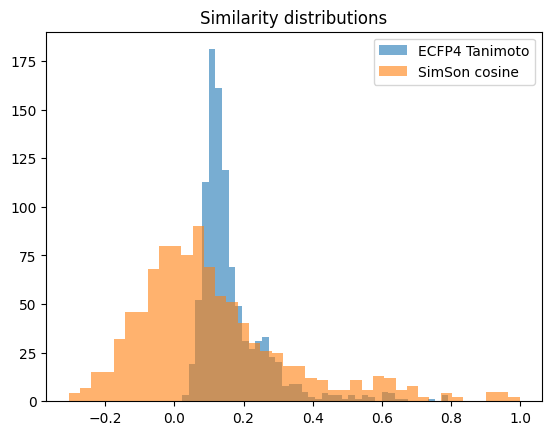

/home/bagugu/molsearch/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


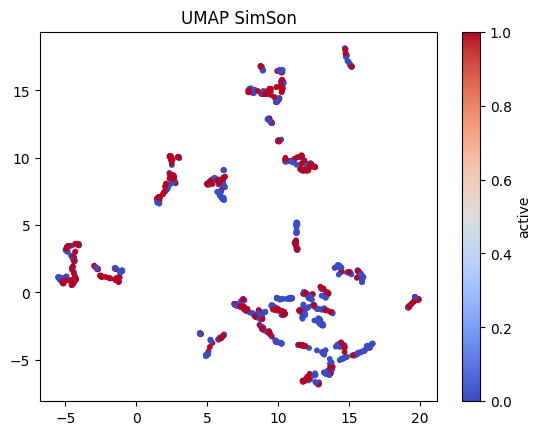

In [12]:
def compute_tanimoto_sample(bitvecs, n=1000):
    n_total = len(bitvecs)
    rng = np.random.default_rng(0)
    pairs = rng.choice(n_total, size=(min(n,n_total),2), replace=True)
    return np.array([DataStructs.TanimotoSimilarity(bitvecs[a],bitvecs[b]) for a,b in pairs])

t_sims = compute_tanimoto_sample(ecfp_bitvecs)
plt.hist(t_sims, bins=40, alpha=0.6, label='ECFP4 Tanimoto')

if simson_emb is not None:
    rng = np.random.default_rng(1)
    n = len(simson_emb)
    pairs = rng.choice(n, size=(min(1000,n),2))
    cos_sims = np.array([simson_emb[a].dot(simson_emb[b]) for a,b in pairs])
    plt.hist(cos_sims, bins=40, alpha=0.6, label='SimSon cosine')

plt.legend(); plt.title('Similarity distributions'); plt.show()

try:
    import umap
    if simson_emb is not None and len(simson_emb)>2:
        emb2 = umap.UMAP(n_components=2, random_state=42).fit_transform(simson_emb)
        plt.scatter(emb2[:,0], emb2[:,1], c=df['active'], cmap='coolwarm', s=10)
        plt.colorbar(label='active'); plt.title('UMAP SimSon'); plt.show()
except Exception:
    print('UMAP unavailable.')

In [13]:
# --- Utility metrics: Recall@k, nDCG@k, EF, BEDROC ---

import numpy as np
from math import exp

def recall_at_k(true_set, retrieved_list, k):
    """True set = indices of relevant items."""
    retrieved_k = retrieved_list[:k]
    return len(set(retrieved_k) & true_set) / max(1, len(true_set))

def dcg(scores):
    """scores: list of relevance scores in ranked order (1 or 0)"""
    return sum(rel / np.log2(i+2) for i, rel in enumerate(scores))

def ndcg_at_k(relevance, k):
    """relevance: binary vector of relevance scores in ranked order."""
    ideal = sorted(relevance, reverse=True)
    return dcg(relevance[:k]) / (dcg(ideal[:k]) + 1e-12)

def enrichment_factor(labels, ranked_indices, top_fraction=0.01):
    """
    EF at 1%, 2%, etc.
    labels: 0/1 activity vector
    ranked_indices: ranking produced by similarity search
    """
    N = len(labels)
    A = labels.sum()
    k = max(1, int(N * top_fraction))
    top_hits = labels[ranked_indices[:k]].sum()
    expected = A * (k / N)
    return top_hits / (expected + 1e-12)

def bedroc_score(labels, ranked_indices, alpha=20.0):
    """
    Truchon & Bayly, JCAMD (2007).
    BEDROC ∈ [0,1], with early-retrieval emphasis.
    """
    N = len(labels)
    A = labels.sum()
    if A == 0 or A == N:
        return np.nan

    # normalizing constant
    K = A
    M = N - A
    C = (1 - exp(-alpha)) / (1 - exp(-alpha * N))

    s = 0.0
    for i, idx in enumerate(ranked_indices):
        if labels[idx] == 1:
            s += exp(-alpha * (i+1))  # rank is 1-based

    rand = K / N * C
    maxi = C * (1 - exp(-alpha * K)) / (1 - exp(-alpha))
    return (s / (A * C) - rand) / (maxi - rand + 1e-12)

In [14]:
# Evaluate: Recall@k, nDCG@k, EF1%, EF5%, BEDROC for all actives as queries

if 'active' not in df.columns:
    print("Dataset lacks 'active' labels — skipping retrieval metrics.")
else:
    labels = df['active'].astype(int).values
    actives = np.where(labels == 1)[0]

    results = []

    ks = [5, 10, 20]

    for qi in tqdm(actives, desc="Benchmarking queries"):

        # ---- ECFP ranking ----
        q_mol = df['rdkit_mol'][qi]
        ecfp_sims = np.array([DataStructs.TanimotoSimilarity(ecfp_bitvecs[qi], b)
                              for b in ecfp_bitvecs])
        ecfp_order = np.argsort(ecfp_sims)[::-1]

        # ---- SimSon ----
        if simson_emb is not None:
            sim_sims = simson_emb.dot(simson_emb[qi])
            sim_order = np.argsort(sim_sims)[::-1]
        else:
            sim_order = None

        true_set = set(actives) - {qi}

        entry = {"query": qi}

        # ----- Classical metrics -----
        for k in ks:
            rel_ecfp = [1 if idx in true_set else 0 for idx in ecfp_order[:k]]
            entry[f"ecfp_recall@{k}"] = recall_at_k(true_set, ecfp_order, k)
            entry[f"ecfp_ndcg@{k}"] = ndcg_at_k(rel_ecfp, k)

        entry["ecfp_ef1"] = enrichment_factor(labels, ecfp_order, 0.01)
        entry["ecfp_ef5"] = enrichment_factor(labels, ecfp_order, 0.05)
        entry["ecfp_bedroc"] = bedroc_score(labels, ecfp_order)

        # ----- SimSon metrics -----
        if sim_order is not None:
            for k in ks:
                rel_sim = [1 if idx in true_set else 0 for idx in sim_order[:k]]
                entry[f"sim_recall@{k}"] = recall_at_k(true_set, sim_order, k)
                entry[f"sim_ndcg@{k}"] = ndcg_at_k(rel_sim, k)

            entry["sim_ef1"] = enrichment_factor(labels, sim_order, 0.01)
            entry["sim_ef5"] = enrichment_factor(labels, sim_order, 0.05)
            entry["sim_bedroc"] = bedroc_score(labels, sim_order)

        results.append(entry)

    metrics_df = pd.DataFrame(results)
    metrics_df.head()


Benchmarking queries: 100%|██████████| 691/691 [00:17<00:00, 39.68it/s]


In [15]:
summary = metrics_df.describe().T[["mean", "std"]]
summary.style.format("{:.4f}")

,mean,std
query,705.5861,477.8060
ecfp_recall@5,0.0044,0.0016
ecfp_ndcg@5,0.6772,0.1524
ecfp_recall@10,0.0098,0.0031
ecfp_ndcg@10,0.7404,0.1302
ecfp_recall@20,0.0198,0.0063
ecfp_ndcg@20,0.7874,0.1138
ecfp_ef1,1.6370,0.4685
ecfp_ef5,1.4185,0.3968
ecfp_bedroc,-0.8406,0.0000


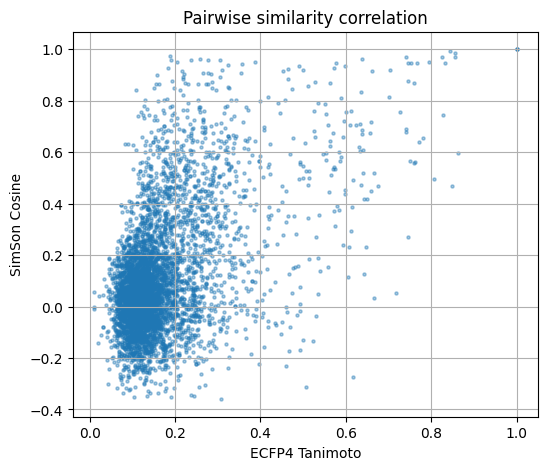

Correlation (ECFP4 vs SimSon): 0.49272569535773386


In [16]:
# Pairwise similarity sampling
rng = np.random.default_rng(123)
pairs = rng.choice(len(df), size=(5000, 2))

ecfp_sim_sample = []
simson_sim_sample = []

for a, b in pairs:
    ecfp_sim_sample.append(
        DataStructs.TanimotoSimilarity(ecfp_bitvecs[a], ecfp_bitvecs[b])
    )
    if simson_emb is not None:
        simson_sim_sample.append(simson_emb[a].dot(simson_emb[b]))

ecfp_sim_sample = np.array(ecfp_sim_sample)
simson_sim_sample = np.array(simson_sim_sample)

plt.figure(figsize=(6,5))
plt.scatter(ecfp_sim_sample, simson_sim_sample, s=5, alpha=0.4)
plt.xlabel("ECFP4 Tanimoto")
plt.ylabel("SimSon Cosine")
plt.title("Pairwise similarity correlation")
plt.grid(True)
plt.show()

# Correlation coefficient
corr = np.corrcoef(ecfp_sim_sample, simson_sim_sample)[0, 1]
print("Correlation (ECFP4 vs SimSon):", corr)


In [ ]:
import seaborn as sns

subset = np.random.choice(len(df), size=200, replace=False)
sim_ecfp = np.zeros((200,200))
sim_simson = np.zeros((200,200))

for i,a in enumerate(subset):
    for j,b in enumerate(subset):
        sim_ecfp[i,j] = DataStructs.TanimotoSimilarity(ecfp_bitvecs[a], ecfp_bitvecs[b])
        if simson_emb is not None:
            sim_simson[i,j] = simson_emb[a].dot(simson_emb[b])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.heatmap(sim_ecfp, cmap="viridis")
plt.title("ECFP4 similarity (subset)")

plt.subplot(1,2,2)
sns.heatmap(sim_simson, cmap="viridis")
plt.title("SimSon cosine similarity (subset)")
plt.show()


# FINAL REPORT EXPORT CELL

In [19]:
# === FINAL EXPORT CELL: Main metrics + auxiliary analyses ===

import numpy as np
import rdkit
from datetime import datetime

# Paths
text_report_path = "benchmark_report.txt"
csv_path = "benchmark_metrics.csv"

# --- Helper to write optional numpy array safely ---
def save_if_exists(obj, path, desc):
    if obj is not None:
        try:
            np.save(path, obj)
            print(f"✔ Saved {desc} → {path}")
        except Exception as e:
            print(f"✖ Failed to save {desc} ({path}): {e}")
    else:
        print(f"… Skipped {desc} (not computed)")

# ==========================================
# 1) WRITE HUMAN-READABLE REPORT
# ==========================================
with open(text_report_path, "w") as f:
    f.write("============================================\n")
    f.write("      Molecular Similarity Benchmark Report\n")
    f.write("============================================\n\n")

    # Metadata
    f.write(f"Timestamp: {datetime.utcnow().isoformat()}\n")
    f.write(f"Dataset size: {len(df)} molecules\n")
    if 'active' in df.columns:
        f.write(f"Actives: {df['active'].sum()}\n")
    f.write("\nEnvironment:\n")
    f.write(f"  RDKit: {rdkit.__version__}\n")
    f.write("  Fingerprint: ECFP4 (2048 bits)\n")
    if 'simson_emb' in globals() and simson_emb is not None:
        f.write(f"  SimSon embedding dim: {simson_emb.shape[1]}\n")
    f.write("\n")

    # Summary table
    f.write("============================================\n")
    f.write("        Summary Statistics (mean ± std)\n")
    f.write("============================================\n")
    for metric in summary.index:
        mean = summary.loc[metric, "mean"]
        std  = summary.loc[metric, "std"]
        f.write(f"{metric:<20}  mean={mean:>8.4f}   std={std:>8.4f}\n")
    f.write("\n")

    # Show first 10 rows of metrics_df
    f.write("============================================\n")
    f.write("        Per-query Results (first 10 rows)\n")
    f.write("============================================\n")
    try:
        f.write(metrics_df.head(10).to_string(index=False))
    except:
        f.write("metrics_df not available.\n")
    f.write("\n\nReport complete.\n")

print(f"✔ Written report → {text_report_path}")

# ==========================================
# 2) EXPORT FULL METRICS DATAFRAME
# ==========================================
try:
    metrics_df.to_csv(csv_path, index=False)
    print(f"✔ Exported metrics_df → {csv_path}")
except:
    print("✖ metrics_df missing — skipping CSV export")

# ==========================================
# 3) SAVE AUXILIARY ANALYSES
# ==========================================

# Pairwise similarity (if you computed full matrices; otherwise skip)
save_if_exists(globals().get("ecfp_similarity", None),
               "ecfp_similarity.npy",
               "ECFP4 pairwise similarity matrix")

save_if_exists(globals().get("simson_cosine", None),
               "simson_cosine.npy",
               "SimSon cosine similarity matrix")

# Sampled distributions
save_if_exists(globals().get("tanimoto_sims", None),
               "tanimoto_sample.npy",
               "sampled ECFP4 Tanimoto similarities")

save_if_exists(globals().get("cos_sims", None),
               "cosine_sample.npy",
               "sampled SimSon cosine similarities")

# Jaccard overlaps
save_if_exists(globals().get("overlaps", None),
               "jaccard_topk.npy",
               "per-query top-k Jaccard overlaps")

# UMAP projection (if computed)
save_if_exists(globals().get("emb2", None),
               "umap_projection.npy",
               "UMAP projection of SimSon embeddings")

print("\n=== Export complete ===")

✔ Written report → benchmark_report.txt
✔ Exported metrics_df → benchmark_metrics.csv
… Skipped ECFP4 pairwise similarity matrix (not computed)
… Skipped SimSon cosine similarity matrix (not computed)
… Skipped sampled ECFP4 Tanimoto similarities (not computed)
✔ Saved sampled SimSon cosine similarities → cosine_sample.npy
✔ Saved per-query top-k Jaccard overlaps → jaccard_topk.npy
✔ Saved UMAP projection of SimSon embeddings → umap_projection.npy

=== Export complete ===


/tmp/ipykernel_1451/817931537.py:31: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.write(f"Timestamp: {datetime.utcnow().isoformat()}\n")
